In [1]:
import os
import json
import xarray as xr
import geopandas as gpd
from odc.stats.tasks import TaskReader
from odc.stats.model import OutputProduct

import datacube
from deafrica_tools.plotting import display_map
from deafrica_tools.dask import create_local_dask_cluster

from ndvi_tools.ndvi_climatology_plugin import NDVIClimatology

## Test functions without odc-stats

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:34271 Dashboard: /user/chad_extra/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


In [3]:
dc = datacube.Datacube(app="Vegetation_anomalies")

In [4]:
lat, lon = 34.5117, -5.9119
buffer = 0.05
# Set the range of dates for the climatology
time_range = ('2014', '2016')
resolution = (-60, 60)

lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

In [5]:
# display_map(x=lon_range, y=lat_range)

In [6]:
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'resolution': resolution,
    'output_crs':'epsg:6933',
    'measurements':['red','nir','pixel_quality'],
    'group_by':'solar_day'
#     'dask_chunks':dask_chunks
}

In [7]:
task = dc.load(product='ls8_sr', dask_chunks={}, **query)

In [8]:
ls7_dss = dc.find_datasets(product='ls7_sr', **query)
ls8_dss = dc.find_datasets(product='ls8_sr', **query)

In [ ]:
# from typing import Any, Dict, Iterable, Optional, Sequence, Tuple

# import xarray as xr
# import numpy as np
# from odc.stats.model import Task
# from datacube.utils import masking
# from odc.algo import keep_good_only, erase_bad
# from odc.algo._masking import mask_cleanup
# from odc.stats.model import StatsPluginInterface
# from odc.stats import _plugins
# from odc.algo.io import load_with_native_transform


# class NDVIClimatology(StatsPluginInterface):
#     NAME = "ndvi_climatology"
#     SHORT_NAME = NAME
#     VERSION = "0.0.1"

#     def __init__(
#         self,
#         resampling: str = "bilinear",
#         bands: Optional[Sequence[str]] = ["red", "nir"],
#         databases: Dict[str, Optional[Any]] = None,
#         mask_band: str = "QA_PIXEL",
#         flags_ls57: Dict[str, Optional[Any]] = dict(
#             cloud="high_confidence", cloud_shadow="high_confidence"
#         ),
#         flags_ls8: Dict[str, Optional[Any]] = dict(
#             cloud="high_confidence",
#             cloud_shadow="high_confidence",
#             cirrus="high_confidence"
#         ),
#         nodata_flags: Dict[str, Optional[Any]] = dict(nodata=False),
#         filters: Optional[Iterable[Tuple[str, int]]] = None,
#         work_chunks: Dict[str, Optional[Any]] = dict(x=400, y=400),
#         scale: float = 0.0000275,
#         offset: float = -0.2,
#         output_dtype: str = "float32",
#         **kwargs,
#     ):

#         self.bands = bands
#         self.mask_band = mask_band
#         self.databases = databases
#         self.input_bands = self.bands.append(mask_band)
#         self.flags_ls57 = flags_ls57
#         self.flags_ls8 = flags_ls8
#         self.resampling = resampling
#         self.nodata_flags = nodata_flags
#         self.filters = filters
#         self.work_chunks = work_chunks
#         self.scale = scale
#         self.offset = offset
#         self.output_dtype = np.dtype(output_dtype)
#         self.output_nodata = np.nan

#     @property
#     def measurements(self) -> Tuple[str, ...]:
#         return self.bands

#     def input_data(self, task: Task) -> xr.Dataset:
#         """
#         Load each of the sensors, remove cloud and poor data,
#         apply scaling coefficients to LS5 & 7 NDVI to mimic
#         NDVI of Landsat 8. Return the harmonized NDVI time series
#         """

#         def masking_data(xx, flags):
#             """
#             Loads in the data in the native projection. It performs the following:

#             1. Loads pq bands
#             2. Extract valid - by removing negative pixel using masking_scale from input bands
#             3. Extract cloud_mask flags from bands
#             4. Drop nodata and negative pixels
#             5. Add cloud_mask band to xx for fuser and reduce
#             """

#             # remove negative pixels - a pixel is invalid if any of the band is smaller than masking_scale
#             valid = (
#                 (xx[self.bands] > (-1.0 * self.offset / self.scale))
#                 .to_array(dim="band")
#                 .all(dim="band")
#             )

#             mask_band = xx[self.mask_band]
#             xx = xx.drop_vars([self.mask_band])

#             flags_def = masking.get_flags_def(mask_band)

#             # set cloud_mask - True=cloud, False=non-cloud
#             mask, _ = masking.create_mask_value(flags_def, **flags)
#             cloud_mask = (mask_band & mask) != 0

#             # set no_data bitmask - True=data, False=no-data
#             nodata_mask, _ = masking.create_mask_value(flags_def, **self.nodata_flags)
#             keeps = (mask_band & nodata_mask) == 0

#             xx = keep_good_only(xx, valid)  # remove negative pixels
#             xx = keep_good_only(xx, keeps)  # remove nodata pixels
#             xx["cloud_mask"] = cloud_mask

#             return xx

#         # load landsat 5 & 7
#         ls57 = load_with_native_transform(
#             dss=self.databases["ls57"],
#             geobox=task.geobox,
#             native_transform=lambda x: masking_data(x, self.flags_ls57),
#             bands=self.bands,
#             chunks=self.work_chunks,
#             resampling=self.resampling,
#         )

#         # load Landsat 8
#         ls8 = load_with_native_transform(
#             dss=self.databases["ls8"],
#             geobox=task.geobox,
#             native_transform=lambda x: masking_data(x, self.flags_ls8),
#             bands=self.bands,
#             chunks=self.work_chunks,
#             resampling=self.resampling,
#         )

#         # add datasets to dict
#         ds = dict(ls57=ls57, ls8=ls8)

#         # Loop through datasets, rescale to SR, calculate NDVI
#         for k in ds:

#             cloud_mask = ds[k]["cloud_mask"]

#             if self.filters is not None:
#                 cloud_mask = mask_cleanup(
#                     ds[k]["cloud_mask"], mask_filters=self.filters
#                 )

#             # erase pixels with cloud
#             ds[k] = ds[k].drop_vars(["cloud_mask"])
#             ds[k] = erase_bad(ds[k], cloud_mask)

#             # rescale bands into surface reflectance scale
#             for band in ds[k].data_vars.keys():
#                 # set nodata_mask - use for resetting nodata pixel after rescale
#                 nodata_mask = ds[k][band] == ds[k][band].attrs.get("nodata")
#                 # rescale
#                 ds[k][band] = self.scale * ds[k][band] + self.offset
#                 #  apply nodata_mask - reset nodata pixels to output-nodata
#                 ds[k][band] = ds[k][band].where(~nodata_mask, self.output_nodata)
#                 # set data-type and nodata attrs
#                 ds[k][band] = ds[k][band].astype(self.output_dtype)
#                 ds[k][band].attrs["nodata"] = self.output_nodata

#             # calculate ndvi
#             ds[k]["ndvi"] = (ds[k].nir - ds[k].red) / (ds[k].nir + ds[k].red)

#         # scaling of 5-7 NDVI to match NDVI 8
#         slope = 0.988
#         intercept = -0.015
#         ds["ls57"]["ndvi"] = (ds["ls57"]["ndvi"] - intercept) / slope

#         # combine datarrays and convert back to dataset
#         ndvi = ds["ls57"].ndvi.combine_first(ds["ls8"].ndvi)
#         ndvi = ndvi.to_dataset(name="ndvi")

#         return ndvi

#     def reduce(self, xx: xr.Dataset) -> xr.Dataset:
#         """
#         Collapse the NDVI time series using mean
#         and std. dev.
#         """
#         ## climatology calulations
#         months = {
#             "jan": [1],
#             "feb": [2],
#             "mar": [3],
#             "apr": [4],
#             "may": [5],
#             "jun": [6],
#             "jul": [7],
#             "aug": [8],
#             "sep": [9],
#             "oct": [10],
#             "nov": [11],
#             "dec": [12],
#         }

#         xx_mean = ndvi.groupby(ndvi.spec["time.month"]).mean()
#         xx_std = ndvi.groupby(ndvi.spec["time.month"]).std()
#         ndvi_var_mean = []
#         ndvi_var_std = []
#         for m in months:
#             ix_mean = xx_mean.sel(month=months[m])
#             ix_mean = (
#                 ix_mean.to_array(name="ndvi_clim_mean_" + m).drop("variable").squeeze()
#             )
#             ix_std = xx_std.sel(month=months[m])
#             ix_std = (
#                 ix_std.to_array(name="ndvi_clim_std_" + m).drop("variable").squeeze()
#             )
#             ndvi_var_mean.append(ix_mean)
#             ndvi_var_std.append(ix_std)

#         clim = xr.merge(ndvi_var_mean + ndvi_var_std, compat="override").drop("month")

#         return clim

In [9]:
config = dict(
    resampling="bilinear",
    datasets=dict(ls57=ls7_dss, ls8=ls8_dss),
    bands=["red", "nir"],
    mask_band="QA_PIXEL",
    mask_filters=[["opening", 5], ["dilation", 5]],
    flags_ls57=dict(cloud="high_confidence", cloud_shadow="high_confidence"),
    flags_ls8=dict(
        cloud="high_confidence",
        cloud_shadow="high_confidence",
        cirrus="high_confidence",
    ),
)

In [10]:
x=NDVIClimatology(**config)
ndvi = x.input_data(task, task)
result = x.reduce(ndvi).compute()
print(result)

CPLReleaseMutex: Error = 1 (Operation not permitted)


<xarray.Dataset>
Dimensions:             (y: 177, x: 162)
Coordinates:
  * y                   (y) float64 4.153e+06 4.153e+06 ... 4.142e+06 4.142e+06
  * x                   (x) float64 -5.752e+05 -5.752e+05 ... -5.656e+05
    spatial_ref         int32 6933
Data variables: (12/24)
    ndvi_clim_mean_jan  (y, x) float32 0.5336 0.6971 0.7583 ... 0.1686 0.5042
    ndvi_clim_mean_feb  (y, x) float32 0.8395 0.8339 0.8163 ... 0.1641 0.5132
    ndvi_clim_mean_mar  (y, x) float32 0.7762 0.7467 0.7364 ... 0.1305 0.3691
    ndvi_clim_mean_apr  (y, x) float32 0.7918 0.7816 0.774 ... 0.3666 0.5566
    ndvi_clim_mean_may  (y, x) float32 0.3793 0.3995 0.4276 ... 0.1666 0.4431
    ndvi_clim_mean_jun  (y, x) float32 0.2316 0.2453 0.2628 ... 0.07528 0.3497
    ...                  ...
    ndvi_clim_std_jul   (y, x) float32 0.01583 0.02171 ... 0.03406 0.01104
    ndvi_clim_std_aug   (y, x) float32 0.1893 0.1644 0.1372 ... 0.03741 0.02671
    ndvi_clim_std_sep   (y, x) float32 0.2965 0.2873 0.2752 ... 0

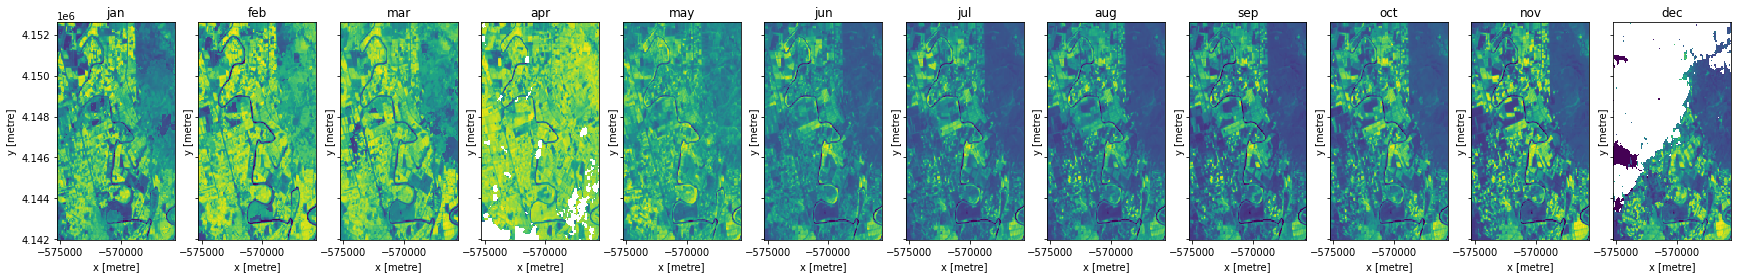

In [11]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,12, sharex=True, sharey=True, figsize=(30,4))
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    result['ndvi_clim_mean_'+j].plot.imshow(ax=ax[i], add_colorbar=False, vmin=0)
    ax[i].set_title(j)

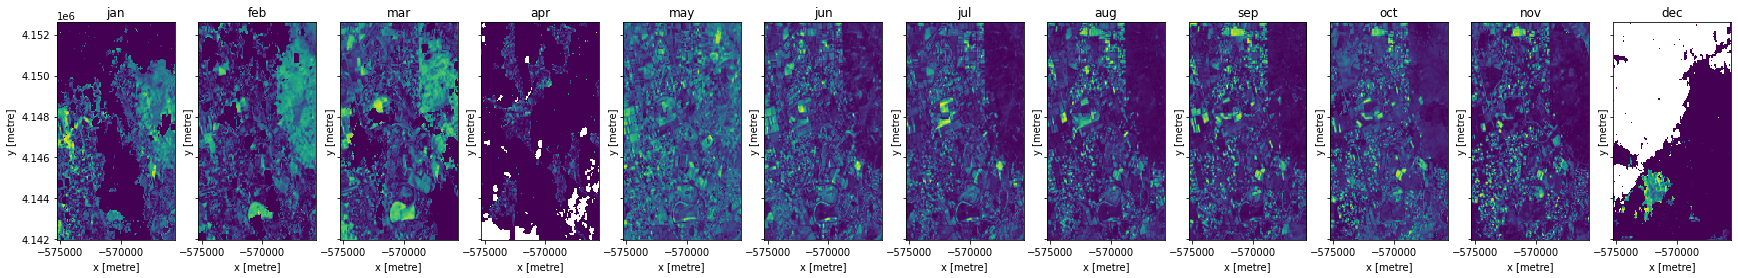

In [12]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,12, sharex=True, sharey=True, figsize=(30,4))
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    result['ndvi_clim_std_'+j].plot.imshow(ax=ax[i], add_colorbar=False)
    ax[i].set_title(j)

## Test functions with odc-stats

In [ ]:
!pip uninstall ndvi_tools -y

In [ ]:
!pip install ndvi_tools/

In [ ]:
import os
# from ndvi_tools.ndvi_climatology_plugin import NDVIClimatology

In [ ]:
# !odc-stats save-tasks --frequency annual --grid africa-30 --temporal-range 2014--P2Y ls7_sr --frequency all --dataset-filter '{"collection_category": "T1"}'
# !odc-stats save-tasks --frequency annual --grid africa-30 --temporal-range 2014--P2Y ls8_sr --frequency all --dataset-filter '{"collection_category": "T1"}'

In [ ]:
%%time
os.system("odc-stats run "\
          "ls8_sr_2014--P2Y.db "\
          "--config=ndvi_climatology.yaml "\
          "--resolution=60 "\
          "--threads=4 "\
          "--memory-limit=29Gi "\
          "--location=file:///home/jovyan/git/deafrica-sandbox-notebooks/frica-sandbox-notebooks/HLS/{product}/{version} "+str(1200)
         )

In [ ]:
# !odc-stats run ls7_sr_2014--P2Y.db --config=ndvi_climatology.yaml --resolution=60 --threads=4 --memory-limit=29Gi --location=file:///home/jovyan/git/deafrica-sandbox-notebooks/frica-sandbox-notebooks/HLS/{product}/{version}

In [ ]:
# taskdb = TaskReader('s3://deafrica-services/crop_mask_eastern/1-0-0/gm_s2_semiannual_all.db', product=op)
# task = taskdb.load_task(('2019--P1Y', t[0], t[1]))